# Load packages and use tensorflow as backend

In [1]:
#####################################################
# Install a pip package in the current Jupyter kernel
# import system level packages
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install requests
#import requests

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
from keras import utils

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
#from .tqdm_callback import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from tensorflow.python.client import device_lib

########################################################
#importing necessary libraries for scikit-learn

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #!!!the grid search package that has issue, dont use it
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from scipy import interp
from scipy import stats

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

Using TensorFlow backend.
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
##################################################
#test tensorflow, remember to change the kernel
#using kernel that supports GPU computing
#simple test to confirm tensorflow is actually working

hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

a = tf.constant(10)
b = tf.constant(32)
print("10 + 32 = ", sess.run(a + b))

#manually set the random seed to define a replication
r_seed = 73

#manually set the number for cross validation
num_cv = 5

print("current random seed is: ", r_seed)

b'Hello, TensorFlow!'
10 + 32 =  42
current random seed is:  73


# Check the system information

In [3]:
#######################################################################################################
#check the system information, check if cuda and gpu computing for tensorflow is installed properly
print("whether tensorflow is built with cuda: ", tf.test.is_built_with_cuda())
print("whether gpu computing is available for tensorflow: ", tf.test.is_gpu_available())
print("using keras version: ", keras.__version__)
print("using tensorflow version: ", tf.__version__)
print("\n")
print("Device details:\n", device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

whether tensorflow is built with cuda:  True
whether gpu computing is available for tensorflow:  True
using keras version:  2.1.3
using tensorflow version:  1.4.1


Device details:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17844579472235397974
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 235864064
locality {
  bus_id: 1
}
incarnation: 15133730609972493507
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Default GPU Device: /device:GPU:0


# Reading files (raw data)

In [4]:
#########################################################################
#Reading files/documents
compress_path = 'counts_data/counts_data_with_label/TCGA_BLCA_(0.2chemo_2labels)VSTnrom_count_expr_clinical_data.txt'
#open(path).readline()
#gene expression RNAseq, Batch effects normalized mRNA data

og_data = pd.read_csv(compress_path, sep = "\t", index_col = 0)
og_data = og_data.dropna(axis='columns')
#ExprAlldata.columns = ["Gene", "Counts"]
print("dimension of the input data: ", og_data.shape)
og_data.head(5)

dimension of the input data:  (115, 12099)


,Ensembl_ID,ENSG00000000003.13,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000280088.1,ENSG00000280111.1,ENSG00000280128.1,ENSG00000280206.1,ENSG00000280734.1,ENSG00000280789.1,ENSG00000280798.1,ENSG00000280832.1,ENSG00000281649.1,response_group
21,TCGA-4Z-AA87-01A,13.260016,11.138559,10.062091,11.332958,8.225093,9.070957,12.406564,12.194558,10.701555,...,8.889123,8.844493,8.801056,9.099730,7.555791,9.202377,8.290387,7.797076,10.986891,1
37,TCGA-BT-A20N-01A,12.195493,11.364738,9.955528,9.798267,7.422188,10.731242,12.334696,13.099981,11.106340,...,7.655183,7.227599,8.455659,8.664066,7.028291,9.002769,8.653169,7.422188,11.042181,1
38,TCGA-BT-A20N-11A,8.883698,10.502061,9.512612,7.849008,9.082273,12.264827,10.547150,11.507223,10.099117,...,8.949048,7.325140,9.604653,9.096969,6.812714,7.587398,10.317539,7.090481,11.096534,1
45,TCGA-BT-A20T-01A,12.492777,10.969511,10.029232,8.554324,8.569969,12.297846,12.216033,11.070859,11.323364,...,8.335595,7.468614,9.625496,8.884969,8.353538,8.675428,8.136894,6.865795,10.342813,1
52,TCGA-BT-A2LA-01A,10.413964,10.867005,9.403899,9.478320,7.151643,8.348445,11.529111,10.105852,10.295408,...,7.901281,6.742442,10.930322,9.374733,6.314344,10.261379,9.855414,7.562071,11.748741,0


## Number of cases in each category

In [5]:
df_count = og_data.groupby('response_group')['Ensembl_ID'].nunique()
print(df_count)
#df_count.nlargest(10)

response_group
0    56
1    59
Name: Ensembl_ID, dtype: int64


In [6]:
###################################################
#store the raw data, and use ensembl id as index
###################################################
df_raw = og_data.iloc[:, 0:]
df_raw = df_raw.set_index('Ensembl_ID')

#notice the last column is the response_group
#df_raw.shape
df_raw.head(3)

,ENSG00000000003.13,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,ENSG00000001460.16,...,ENSG00000280088.1,ENSG00000280111.1,ENSG00000280128.1,ENSG00000280206.1,ENSG00000280734.1,ENSG00000280789.1,ENSG00000280798.1,ENSG00000280832.1,ENSG00000281649.1,response_group
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-4Z-AA87-01A,13.260016,11.138559,10.062091,11.332958,8.225093,9.070957,12.406564,12.194558,10.701555,12.571436,...,8.889123,8.844493,8.801056,9.099730,7.555791,9.202377,8.290387,7.797076,10.986891,1
TCGA-BT-A20N-01A,12.195493,11.364738,9.955528,9.798267,7.422188,10.731242,12.334696,13.099981,11.106340,9.393430,...,7.655183,7.227599,8.455659,8.664066,7.028291,9.002769,8.653169,7.422188,11.042181,1
TCGA-BT-A20N-11A,8.883698,10.502061,9.512612,7.849008,9.082273,12.264827,10.547150,11.507223,10.099117,7.859792,...,8.949048,7.325140,9.604653,9.096969,6.812714,7.587398,10.317539,7.090481,11.096534,1


In [7]:
#####################################!#################################
#here begins full data
################################
#full data, 4 labels analysis
#Complete Response    21
#Clinical Progressive Disease    10
#Radiographic Progressive Disease     7
#Stable Disease     7

#features
df_raw_coln = len(df_raw.columns)
X = df_raw.iloc[:,0:(df_raw_coln-1)]
X = X.values

#label/target
y = df_raw.loc[:, 'response_group']
y = y.values

#!!!!!!!
#check to confirm the last column is not response group, only y contains response group information
col = X.shape[1]
#print(X[:,(col-1)])

#df_cancer.head(10)
#df_normal.head(10)

class_names = np.unique(y)
print("unique labels from y: ", class_names)

unique labels from y:  [0 1]


In [8]:
#One-hot encoding y
#y = label_binarize(y, classes=[1, 2, 3, 4])
#y

# Load necessary methods

In [9]:
#########################################################################################
#plot confusion matrix
#inputs: cm, confusion matrix from cross_val_predict
#        normalize, whether to use normalize for each sections 
#        title, input the title name for the figure
#        cmap, color map using blue as default
#output: a confusion matrix plot with true label as y axis, and predicted label as x axis
#########################################################################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
##############################################################
#plot area under curve graph
#input: actual, true labels/target without one hot encoding
#       probs, predicted probabilities
#       n_classes, number of unique classes in target
#       title, input the title name for the figure
#output: a roc curve plot for multi class task
###############################################################
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle

def plot_multiclass_roc_auc(actual, probs, n_classes, title = 'multi-class roc'):
    lb = LabelBinarizer()
    lb.fit(actual)
    actual = lb.transform(actual)
    y_prob = probs
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actual[:, i], y_prob[:, i])
        #please notice the difference between auc() and roc_auc_score()
        #also auc() only works on monotonic increasing or monotonic
        #decreasing input x
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
        label='ROC curve of class {0} (area = {1:0.10f})'
            ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data using '+title)
    plt.legend(loc="lower right")
    #commented thus being able to use fig save function
    #plt.show()

In [11]:
#######################################################
#Random search CV method
#and
#Multi class roc_auc score method
########################################################
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer, roc_auc_score

###########################################################################################
#Multi class roc_auc score method
#input: y_test, true labels from test fold
#       y_prob, predicted probability on test fold
#       average, string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
#                'macro': Calculate metrics for each label, and find their unweighted mean. 
#                This does not take label imbalance into account.
#                'weighted': Calculate metrics for each label, and find their average, 
#                weighted by support (the number of true instances for each label).
#output: auroc value for each class
#multiclass_score, an implemented scoring method for multi class task
#!!!
#Notice that by default,needs_proba : boolean, default=False
#thus the multiclass_score will try to use the predicted label instead of predicted probability to calculate roc
#which is not correct, and will causing the tuning process to not find the best parameters
##############################################################################################
def multiclass_roc_auc_score(y_test, y_prob, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    #y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_prob, average=average)

#!!!
#Notice that by default,needs_proba : boolean, default=False
#thus the multiclass_score will try to use the predicted label instead of predicted probability to calculate roc
#which is not correct, and will causing the tuning process to not find the best parameters
multiclass_score = make_scorer(multiclass_roc_auc_score, needs_proba = True)


###############################################################################################
#Binary class roc auc score method
#input: y_true, true labels from test fold
#       y_score, predicted probability on test fold
#       average, string, [None, ‘micro’, ‘macro’ (default), ‘samples’, ‘weighted’]
#                'macro': Calculate metrics for each label, and find their unweighted mean. 
#                This does not take label imbalance into account.
#                'weighted': Calculate metrics for each label, and find their average, 
#                weighted by support (the number of true instances for each label).
#output: auroc value for each class
#############################################################################################
def binary_class_roc_auc_score(y_true, y_score, average="weighted"):

    return roc_auc_score(y_true, y_score, average=average)

binaryclass_score = make_scorer(binary_class_roc_auc_score, needs_threshold = True)

###################################################################################
#Random search CV method
#input: est, input estimator/classifier
#       p_distr, the grid of parameters to search on
#       nbr_iter, numbers of iteration on random search
#       X, feature, y, true labels
#output: ht_estimator, best estimator based on mean value of all folds
#        ht_params, best parameters
#
################################################################################################
def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    #seed = 42
    cv = StratifiedKFold(n_splits = 3, random_state = r_seed, shuffle = True)
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr, scoring=multiclass_score,
                                  n_jobs=-1, n_iter=nbr_iter, cv=cv, return_train_score = True, verbose =10)
    #CV = Cross-Validation ( here using Stratified KFold CV) #,random_state = seed
    start = time()
    rdmsearch.fit(X,y)
    print('hyper-tuning time : %d seconds' % (time()-start))
    start = 0
   # ht_train_mean = rdmsearch.cv_results_['mean_train_score']
   # ht_train_std = rdmsearch.cv_results_['std_train_score']
   # ht_test_mean_sp0 = rdmsearch.cv_results_['split0_test_score']
   # ht_test_mean_sp1 = rdmsearch.cv_results_['split1_test_score']
   # ht_test_mean_sp2 = rdmsearch.cv_results_['split2_test_score']
    #ht_train_mean_sp3 = rdmsearch.cv_results_['split3_train_score']
    #ht_train_mean_sp4 = rdmsearch.cv_results_['split4_train_score']
    #ht_best_loc = np.where(rdmsearch.cv_results_['rank_test_score'] == 1)
    
    ht_cv_results = rdmsearch.cv_results_
    ht_estimator = rdmsearch.best_estimator_
    ht_params = rdmsearch.best_params_
    #ht_score = rdmsearch.best_score_
    
    return ht_estimator, ht_params, ht_cv_results

# Grid search

In [12]:
###########################################################
#Grid search Tune learning rate, n_estimators, and booster
#
##########################################################
param_test_this_loop = {
 'learning_rate':[0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
 'n_estimators':[i for i in range(1,40)],
 'booster':['gbtree'],
 #'booster':['gbtree','gblinear','dart'],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop1 = GridSearchCV(estimator = XGBClassifier(booster = 'gbtree'), 
 param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop1.fit(X,y)
gsearch_loop1.grid_scores_, gsearch_loop1.best_params_, gsearch_loop1.best_score_

Fitting 5 folds for each of 234 candidates, totalling 1170 fits
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=1, score=0.46180555555555564, total=   0.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2 
[CV]  random_state=73, b

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s


[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=3 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2, score=0.46590909090909094, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2, score=0.5454545454545454, total=   0.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=2, score=0.4669421487603305, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=3, score=0.4507575757575758, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, 

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=3, score=0.40530303030303033, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=3, score=0.625, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=3, score=0.5, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4, score=0.45833333333333337, total=   0.5s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=4, score=0.3680555555555556, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5 
[CV] random_state=73, booster=gbtree, 

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5, score=0.3854166666666667, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5, score=0.48863636363636365, total=   0.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5, score=0.446969696969697, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5, score=0.5454545454545454, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=5, score=0.45041322314049587, total=   0.6s
[CV] random

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6, score=0.42803030303030304, total=   0.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6, score=0.5719696969696969, total=   0.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6, score=0.5, total=   0.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=6, score=0.4504132231404958, total=   0.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=7, score=0.3888888888888889, total=   0.8s
[CV] random_state=73, boos

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8, score=0.35416666666666663, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8, score=0.4507575757575758, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8, score=0.5151515151515151, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=8, score=0.42148760330578516, total=   1.0s
[CV] ran

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.3s


[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10, score=0.4696969696969697, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10, score=0.5075757575757576, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10, score=0.5, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=10, score=0.4628099173553719, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learnin

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.2s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12, score=0.5303030303030303, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12, score=0.5075757575757576, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=12, score=0.5041322314049587, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=13, score=0.375, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=13, score=0.4772727272727273, total=   1.5s
[CV] random_stat

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.4s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=14, score=0.4876033057851239, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=15, score=0.38888888888888884, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=15, score=0.49242424242424243, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=15, score=0.5909090909090909, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=17 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=15, score=0.47727272727272735, total=   1.7s


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.5s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=17, score=0.5, total=   1.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=17, score=0.4876033057851239, total=   1.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=18, score=0.39583333333333337, total=   1.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=18, score=0.46212121212121215, total=   1.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=18, score=0.5757575757575758, total=   2.0s
[CV] random_stat

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.4s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=20, score=0.5075757575757576, total=   2.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=22 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=20, score=0.48760330578512395, total=   2.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=22 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=21, score=0.3680555555555556, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=22 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=21, score=0.4696969696969697, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=22 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=21, score=0.5833333333333333, total=   2.3s
[C

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.7s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=23, score=0.5681818181818181, total=   2.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=23, score=0.4696969696969697, total=   2.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=23, score=0.5123966942148761, total=   2.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=24, score=0.36111111111111116, total=   2.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=24, score=0.4621212121212121, total=   2.6s
[C

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.3s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=26, score=0.5123966942148761, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=27, score=0.3472222222222222, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=27, score=0.4696969696969697, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=27, score=0.5681818181818181, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=29 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=27, score=0.48484848484848486, total=   2.8s
[C

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.7s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=30, score=0.4772727272727273, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=31 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=30, score=0.5757575757575757, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=32 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=30, score=0.5, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=32 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=30, score=0.512396694214876, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=32 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=31, score=0.3680555555555556, total=   3.1s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   39.5s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=34, score=0.3680555555555555, total=   3.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=34, score=0.5, total=   3.5s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=34, score=0.5833333333333333, total=   3.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=35 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=36 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=34, score=0.49242424242424243, total=   3.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=36 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=34, score=0.5041322314049587, total=   3.5s
[CV] random_state

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   48.4s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=37, score=0.4958677685950412, total=   3.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=38, score=0.3541666666666667, total=   3.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=38, score=0.5227272727272727, total=   3.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=38, score=0.5681818181818181, total=   3.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=1 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=38, score=0.5151515151515151, total=   3.8s
[CV] 

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   52.4s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=3, score=0.45041322314049587, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=4, score=0.3229166666666667, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.05, n_estimators=39, score=0.5757575757575757, total=   4.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=4, score=0.46590909090909094, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=4, score=0.5568181818181819, total=   0.5s
[CV] random_state

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   54.4s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=7, score=0.5378787878787878, total=   0.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=7, score=0.625, total=   0.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=7, score=0.47933884297520657, total=   0.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=8, score=0.3819444444444444, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=9 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=8, score=0.5, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=Tru

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   57.7s


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=12, score=0.3819444444444444, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=13 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=12, score=0.5151515151515151, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=13 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=12, score=0.49242424242424243, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=12, score=0.5606060606060606, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=14 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=12, score=0.47933884297520657, total=   1.3s
[CV] rando

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.0min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=16, score=0.5303030303030303, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=16, score=0.5041322314049588, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=17, score=0.3472222222222222, total=   1.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=17, score=0.4848484848484848, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=17, score=0.553030303030303, total=   1.7s
[CV] random_s

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  1.1min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=21, score=0.5681818181818182, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=23 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=21, score=0.537878787878788, total=   2.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=23 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=21, score=0.5041322314049588, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=23 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=22, score=0.3819444444444444, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=23 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=22, score=0.5227272727272727, total=   2.2s
[CV] random_s

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  1.3min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=26, score=0.5984848484848485, total=   2.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=26, score=0.5227272727272727, total=   2.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=26, score=0.487603305785124, total=   2.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=27, score=0.3819444444444444, total=   2.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=27, score=0.5151515151515151, total=   2.7s
[CV] random_s

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=31, score=0.4545454545454546, total=   3.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=32, score=0.35416666666666663, total=   3.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=32, score=0.5075757575757576, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=32, score=0.6060606060606061, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=34 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=32, score=0.5, total=   3.1s
[CV] random_state=73, boos

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.6min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=37, score=0.5303030303030303, total=   3.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=38 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=37, score=0.5757575757575757, total=   3.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=37, score=0.5, total=   3.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=37, score=0.44628099173553715, total=   3.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=39 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=38, score=0.3680555555555555, total=   3.6s
[CV] random_state=73, boos

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  1.7min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.1, n_estimators=39, score=0.49242424242424243, total=   3.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=5, score=0.4131944444444445, total=   0.6s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=5, score=0.46590909090909094, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=6 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=5, score=0.49242424242424243, total=   0.7s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=5, score=0.4166666666666667, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=6 
[CV] random_state

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=10, score=0.3472222222222222, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=10, score=0.5681818181818182, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=10, score=0.5378787878787878, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=10, score=0.487603305785124, total=   1.1s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=10, score=0.5227272727272727, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=12 
[CV] random_s

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.9min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=16, score=0.553030303030303, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=17 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=16, score=0.5151515151515151, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=16, score=0.48484848484848486, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=16, score=0.5041322314049587, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=18 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=17, score=0.33333333333333337, total=   1.7s
[CV] random

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.0min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=22, score=0.5909090909090908, total=   2.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=23 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=22, score=0.5378787878787878, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=22, score=0.5, total=   2.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=22, score=0.4628099173553719, total=   2.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=23, score=0.3680555555555556, total=   2.1s
[CV] random_state=73, boost

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  2.1min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=28, score=0.4545454545454546, total=   2.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=30 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=29, score=0.3402777777777778, total=   2.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=30 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=29, score=0.5303030303030303, total=   2.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=30 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=29, score=0.5075757575757576, total=   2.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=31 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=29, score=0.5303030303030303, total=   2.5s
[CV] random_

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  2.3min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=35, score=0.5227272727272727, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=35, score=0.4545454545454546, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=35, score=0.5833333333333334, total=   3.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=36, score=0.5378787878787878, total=   2.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=36, score=0.38888888888888884, total=   2.9s
[CV] random

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  2.5min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.2, n_estimators=39, score=0.5303030303030303, total=   3.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=4, score=0.5227272727272727, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=4, score=0.5, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=4, score=0.5303030303030303, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=4, score=0.4793388429752067, total=   0.5s
[CV] random_state=73, booster=gbtre

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=10, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=10, score=0.487603305785124, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=11, score=0.45833333333333337, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=11, score=0.49242424242424243, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=11, score=0.553030303030303, total=   1.1s
[CV] random_

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  2.6min


[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=18, score=0.49242424242424243, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=18, score=0.5075757575757576, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=18, score=0.5606060606060607, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=18, score=0.4793388429752067, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, 

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.7min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=25, score=0.46212121212121215, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=26 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=25, score=0.5227272727272727, total=   1.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=27 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=25, score=0.5606060606060606, total=   1.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=27 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=25, score=0.487603305785124, total=   1.8s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=27 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=26, score=0.4375, total=   1.8s
[CV] random_state=73, bo

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=34 


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  2.9min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=33, score=0.4791666666666667, total=   2.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=34 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=33, score=0.48484848484848486, total=   2.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=34 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=33, score=0.5, total=   2.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=33, score=0.5681818181818181, total=   2.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=33, score=0.4545454545454546, total=   2.1s
[CV] random_state=73, boos

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=2, score=0.45833333333333337, total=   0.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=39, score=0.4772727272727273, total=   2.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3 


[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=2, score=0.6487603305785125, total=   0.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.4, n_estimators=39, score=0.49242424242424243, total=   2.2s
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3, score=0.4340277777777778, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=4 
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3, score=0.46590909090909094, total=   0.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=4 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=3, score=0.5189393939393939, total=   0.4s
[CV] random_state=

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=10, score=0.4772727272727273, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=11 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=9, score=0.5950413223140496, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=11 


[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  3.1min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=10, score=0.5757575757575758, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=10, score=0.46212121212121215, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=10, score=0.5950413223140496, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=11, score=0.42361111111111116, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=12 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=11, score=0.4772727272727273, total=   1.0s
[CV] rando

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=18, score=0.44444444444444453, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=19 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=18, score=0.5984848484848485, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=20 


[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  3.2min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=18, score=0.4469696969696969, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=18, score=0.5950413223140496, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=19, score=0.4375, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=19, score=0.4772727272727273, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=20 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=19, score=0.6060606060606061, total=   1.3s
[CV] random_state=73, bo

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=26, score=0.5075757575757576, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=26, score=0.6060606060606061, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=26, score=0.5867768595041323, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=28 


[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  3.3min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27, score=0.45138888888888895, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27, score=0.4318181818181818, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=28 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27, score=0.6060606060606061, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=29 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27, score=0.5075757575757576, total=   1.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=29 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=27, score=0.5867768595041323, total=   1.5s
[CV] random

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=34, score=0.5075757575757576, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=35, score=0.45138888888888895, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=35, score=0.4318181818181818, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36 


[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  3.5min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=35, score=0.6060606060606061, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=35, score=0.5867768595041323, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=35, score=0.5075757575757576, total=   1.7s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36, score=0.4318181818181818, total=   1.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=37 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.6, n_estimators=36, score=0.45138888888888895, total=   1.6s
[CV] random

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=4, score=0.5075757575757576, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=5 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=4, score=0.45075757575757575, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=4, score=0.38636363636363635, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=4, score=0.6157024793388429, total=   0.5s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6 
[CV]  random_state=73, booster=gbtree, silent=True, learning

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.6min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=5, score=0.615702479338843, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6, score=0.47916666666666674, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6, score=0.4696969696969697, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=7 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6, score=0.5303030303030303, total=   0.6s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=8 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=6, score=0.36363636363636365, total=   0.6s
[CV] random_state=73

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=13, score=0.4015151515151515, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=13, score=0.5619834710743802, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=14, score=0.6060606060606061, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=14, score=0.5, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:  3.7min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=14, score=0.578512396694215, total=   0.9s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15, score=0.4652777777777778, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15, score=0.5227272727272727, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=16 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15, score=0.6287878787878788, total=   1.0s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=17 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=15, score=0.4015151515151515, total=   1.0s
[CV] random_s

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=22, score=0.38636363636363635, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=22, score=0.578512396694215, total=   1.1s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=23, score=0.45833333333333337, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=23, score=0.5075757575757576, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24 
[CV]  random_state=73, booster=gbtree, silent=True, 

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:  3.8min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24, score=0.45833333333333337, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24, score=0.5075757575757576, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=25 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24, score=0.6212121212121212, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=26 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24, score=0.38636363636363635, total=   1.2s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=26 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=24, score=0.578512396694215, total=   1.2s
[CV] random

[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=31, score=0.38636363636363635, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=32, score=0.45833333333333337, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=32, score=0.5075757575757576, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=32, score=0.6212121212121212, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=34 
[CV]  random_state=73, booster=gbtree, silent=True,

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.9min


[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33, score=0.6212121212121212, total=   1.4s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33, score=0.38636363636363635, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=33, score=0.578512396694215, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=34, score=0.45833333333333337, total=   1.3s
[CV] random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=35 
[CV]  random_state=73, booster=gbtree, silent=True, learning_rate=0.8, n_estimators=34, score=0.5075757575757576, total=   1.4s
[CV] random

[Parallel(n_jobs=-1)]: Done 1170 out of 1170 | elapsed:  4.0min finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.46695, std: 0.09759, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 1},
  mean: 0.48859, std: 0.03000, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 2},
  mean: 0.47746, std: 0.08157, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 3},
  mean: 0.45385, std: 0.06369, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 4},
  mean: 0.46338, std: 0.05271, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 5},
  mean: 0.46439, std: 0.06780, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 6},
  mean: 0.46566, std: 0.05192, params: {'random_state': 73, 'booster': 'gbtree', 'silent': True, 'learning_rate': 0.05, 'n_estimators': 7},
  mean: 0.45740, std

In [13]:
##########################################################
#output grid scores, and save to a file
#
#xgb_grid_scores = pd.DataFrame(gsearch1.grid_scores_)
#xgb_grid_file = os.path.join("Tuning_insights", "xgb_grid_socres(lr&n_estimators).tsv")
#xgb_grid_scores.to_csv(xgb_grid_file, sep='\t')

# Test to make sure the parameters are correct
#gsearch_loop1.best_params_
#gsearch_loop1.best_params_["learning_rate"]
#gsearch_loop1.best_params_["booster"]
#gsearch_loop1.best_params_["n_estimators"]

In [14]:
#################################################
#Grid search Tune max_depth and min_child_weight
#default
#################################################
param_test_this_loop = {
 'max_depth':[i for i in range(1,10)],
 'min_child_weight':[i for i in range(0,10)],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop2 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                  n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                  booster = gsearch_loop1.best_params_["booster"]), 
param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop2 .fit(X,y)
gsearch_loop2 .grid_scores_, gsearch_loop2 .best_params_, gsearch_loop2 .best_score_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=0 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=0 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=0 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=0 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=0 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=1 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=1 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=0, score=0.5208333333333333, total=   0.8s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=1, score=0.5208333333333333, total=   0.8s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=1 ...
[CV]  rand

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s


[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=2, score=0.5208333333333333, total=   0.7s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=2, score=0.5075757575757576, total=   0.8s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=1, score=0.4214876033057851, total=   0.8s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=2, score=0.5378787878787878, total=   0.8s
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=1, score=0.40909090909090906, total=   0.9s
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=3, score=0.4444444444444444, total=   0.7s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_we

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s


[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=4, score=0.48484848484848486, total=   0.6s
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=3, score=0.4696969696969697, total=   0.7s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=5 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=4 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=4, score=0.5757575757575757, total=   0.6s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=3, score=0.40151515151515155, total=   0.7s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=4, score=0.5486111111111112, total=   0.7s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=3, score=0.4696969696969697, tot

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s


[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=6, score=0.5151515151515151, total=   0.6s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=6, score=0.75, total=   0.5s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=6, score=0.7878787878787878, total=   0.6s
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=7, score=0.40972222222222227, total=   0.5s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=8 ...
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=7, score=0.6439393939393939, total=   0.5s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=7, score=0.42803030303030304, total=   0.6s
[CV

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s


[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=7, score=0.45867768595041325, total=   0.6s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=8, score=0.5227272727272727, total=   0.5s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=8, score=0.48611111111111116, total=   0.5s
[CV] random_state=73, max_depth=1, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=8, score=0.6098484848484849, total=   0.5s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=0 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=9, score=0.5104166666666667, total=   0.5s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=0 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=8, score=0.5037878787878788, tot

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.3s


[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=9, score=0.47520661157024796, total=   0.5s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=1, silent=True, min_child_weight=9, score=0.6553030303030303, total=   0.5s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=1, score=0.4930555555555556, total=   1.1s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=1, score=0.4772727272727273, total=   1.1s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=1, score=0.5606060606060607, total=   1.1s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=0, score=0.4375, total=   1.6s
[C

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.0s


[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=1, score=0.4090909090909091, total=   1.1s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=2, score=0.49242424242424243, total=   0.9s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=2, score=0.4444444444444444, total=   1.0s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=1, score=0.47933884297520657, total=   1.1s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=2, score=0.49242424242424243, total=   1.0s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=4 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=3, score=0.2222222222222222, to

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.8s


[CV] random_state=73, max_depth=2, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=4, score=0.5227272727272727, total=   0.9s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=4, score=0.3801652892561983, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=5, score=0.4652777777777778, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=5, score=0.5984848484848485, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=5, score=0.803030303030303, total=   0.8s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_dep

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.8s


[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=6, score=0.6136363636363636, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=6, score=0.4621212121212121, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=6, score=0.4380165289256198, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=7, score=0.40972222222222227, total=   0.7s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=7, score=0.42803030303030304, total=   0.6s
[CV] random_state=73, max_depth=2, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=7, score=0.45867768595041325, to

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.1s


[CV]  random_state=73, max_depth=2, silent=True, min_child_weight=9, score=0.47520661157024796, total=   0.6s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=1, score=0.45833333333333337, total=   1.2s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=1, score=0.4696969696969697, total=   1.3s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=1, score=0.6060606060606061, total=   1.4s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=0, score=0.3181818181818182, total=   2.3s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=0, score=0.3125, total=   2.4s
[

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.5s


[CV] random_state=73, max_depth=3, silent=True, min_child_weight=4 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=3, score=0.5757575757575758, total=   0.9s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=3, score=0.6363636363636365, total=   1.0s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=4, score=0.4722222222222222, total=   0.9s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=4, score=0.44696969696969696, total=   0.9s
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=3, score=0.4297520661157025, total=   1.0s
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=4, score=0.49242424242424243, total=   0.9s
[CV]  random_state=73, max_depth=3, silent=True, min_child_w

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   15.3s


[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=6, score=0.4380165289256198, total=   0.8s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=7, score=0.40972222222222227, total=   0.6s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=7, score=0.42803030303030304, total=   0.7s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=7, score=0.45867768595041325, total=   0.6s
[CV] random_state=73, max_depth=3, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=7, score=0.5681818181818181, total=   0.7s
[CV]  random_state=73, max_depth=3, silent=True, min_child_weight=8, score=0.48611111111111116, total=   0.6s
[CV] random_state=73, max_depth=3, silent=True, min_child_

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.7s


[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=1, score=0.3125, total=   1.4s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=1, score=0.4696969696969697, total=   1.4s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=1, score=0.6742424242424242, total=   1.5s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=0, score=0.4166666666666667, total=   3.1s
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=2, score=0.27083333333333337, total=   1.1s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=2 ...
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=0, score=0.49242424242424243, total=   3.0s
[

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   20.8s


[CV] random_state=73, max_depth=4, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=4, score=0.4722222222222222, total=   0.8s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=4, score=0.44696969696969696, total=   0.9s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=3, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=5 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=4, score=0.3801652892561983, total=   0.8s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=4, score=0.49242424242424243, total=   0.9s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s


[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=7, score=0.42803030303030304, total=   0.6s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=7, score=0.40972222222222227, total=   0.7s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=7, score=0.5681818181818181, total=   0.7s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=7, score=0.5909090909090909, total=   0.7s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=8, score=0.48611111111111116, total=   0.6s
[CV] random_state=73, max_depth=4, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=4, silent=True, min_child_weight=8, score=0.5227272727272727, to

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   26.9s


[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=0, score=0.6212121212121212, total=   3.6s
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=0, score=0.5227272727272727, total=   3.6s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=0, score=0.5833333333333334, total=   3.6s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=3 ...
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=0, score=0.5371900826446281, total=   3.7s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=2, score=0.4621212121212121, total=   1.1s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=2, score=0.5757575757575757, total

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   29.4s


[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=5, score=0.803030303030303, total=   0.8s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=5, score=0.5289256198347108, total=   0.8s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=5, score=0.6060606060606061, total=   0.9s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=6, score=0.3472222222222222, total=   0.8s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=6, score=0.5681818181818182, total=   0.7s
[CV] random_state=73, max_depth=5, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=5, silent=True, min_child_weight=6, score=0.4621212121212121, total=

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   31.4s


[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=1, score=0.3125, total=   1.4s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=1, score=0.4696969696969697, total=   1.5s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=1, score=0.6742424242424242, total=   1.6s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=2, score=0.27083333333333337, total=   1.1s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=1, score=0.578512396694215, total=   1.4s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=1, score=0.5606060606060606, total=   1.5s
[CV

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   36.6s


[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=5, score=0.4652777777777778, total=   0.8s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=5, score=0.5984848484848485, total=   0.8s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=5, score=0.803030303030303, total=   0.8s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=5, score=0.6060606060606061, total=   0.8s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=5, score=0.5289256198347108, total=   0.8s
[CV] random_state=73, max_depth=6, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=6, silent=True, min_child_weight=6, score=0.3472222222222222, total=

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   38.8s


[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=1, score=0.3125, total=   1.4s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=1, score=0.4696969696969697, total=   1.4s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=1, score=0.6742424242424242, total=   1.5s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=2, score=0.27083333333333337, total=   1.1s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=1, score=0.578512396694215, total=   1.4s
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=1, score=0.5606060606060606, total=   1.5s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=2 ...
[CV

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   43.9s


[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=4, score=0.49242424242424243, total=   0.9s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=4, score=0.3801652892561983, total=   0.8s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=4, score=0.41666666666666663, total=   1.0s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=5, score=0.4652777777777778, total=   0.8s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=5, score=0.5984848484848485, total=   0.8s
[CV] random_state=73, max_depth=7, silent=True, min_child_weight=6 ...
[CV]  random_state=73, max_depth=7, silent=True, min_child_weight=5, score=0.6060606060606061, tot

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.4s


[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=1, score=0.4696969696969697, total=   1.4s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=1, score=0.3125, total=   1.5s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=1 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=1, score=0.6742424242424242, total=   1.5s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=2, score=0.27083333333333337, total=   1.0s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=1, score=0.5606060606060606, total=   1.5s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=2 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=1, score=0.578512396694215, total=   1.5s
[CV

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   51.8s


[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=5, score=0.803030303030303, total=   0.8s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=5, score=0.5289256198347108, total=   0.8s
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=5, score=0.6060606060606061, total=   0.8s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=7 ...
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=6, score=0.3472222222222222, total=   0.7s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=6, score=0.5681818181818182, total=   0.8s
[CV] random_state=73, max_depth=8, silent=True, min_child_weight=7 ...
[CV]  random_state=73, max_depth=8, silent=True, min_child_weight=6, score=0.6136363636363636, total=

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   56.7s


[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=0, score=0.5371900826446281, total=   3.5s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=0, score=0.5227272727272727, total=   3.7s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=0, score=0.5833333333333334, total=   3.7s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=0, score=0.5757575757575757, total=   3.9s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=2, score=0.4621212121212121, total=   1.1s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=3 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=2, score=0.47727272727272724, tota

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min


[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=7, score=0.42803030303030304, total=   0.6s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=7, score=0.40972222222222227, total=   0.7s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=8 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=7, score=0.5909090909090909, total=   0.7s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=7, score=0.5681818181818181, total=   0.7s
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=7, score=0.45867768595041325, total=   0.7s
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=9 ...
[CV] random_state=73, max_depth=9, silent=True, min_child_weight=9 ...
[CV]  random_state=73, max_depth=9, silent=True, min_child_weight=8, score=0.48611111111111116, t

[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.0min finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.47937, std: 0.05334, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 0},
  mean: 0.47937, std: 0.05334, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 1},
  mean: 0.47937, std: 0.05334, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 2},
  mean: 0.44137, std: 0.02683, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 3},
  mean: 0.52777, std: 0.05349, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 4},
  mean: 0.50437, std: 0.08685, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 5},
  mean: 0.61126, std: 0.14567, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 6},
  mean: 0.50171, std: 0.08988, params: {'random_state': 73, 'max_depth': 1, 'silent': True, 'min_child_weight': 7},
  mean: 0.50879, std: 0.06094, params: {'random_state': 73, 'max_depth':

In [15]:
##########################################
#Grid search Tune subsample and colsample
#
##########################################
param_test_this_loop = {
             'subsample':[i/100.0 for i in range(10,110,10)],
             'colsample_bytree':[i/100.0 for i in range(10,110,10)],
             
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop3 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                      n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                      booster = gsearch_loop1.best_params_["booster"],
                                                      max_depth =gsearch_loop2.best_params_["max_depth"],
                                                      min_child_weight=gsearch_loop2.best_params_["min_child_weight"]), 
  param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop3.fit(X,y)
gsearch_loop3.grid_scores_, gsearch_loop3.best_params_, gsearch_loop3.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.1, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2 
[CV]  random_state=73

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s


[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.3, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.2, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.3, score=0.5, total=   0.2s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.3, score

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s


[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4, score=0.4810606060606061, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4, score=0.43560606060606066, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5, score=0.5243055555555556, total=   0.2s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4, score=0.5227272727272727, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6 
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.4, score=0.54545454

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s


[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5, score=0.7007575757575758, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5, score=0.43388429752066116, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.5, score=0.7007575757575758, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6, score=0.4722222222222222, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.6, score=0.5227272727272727, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7 
[C

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.6805555555555556, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.7575757575757576, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.553030303030303, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.8, score=0.3819444444444444, total=   0.2s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.5206611570247934, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.7, score=0.45454545454545453, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9 
[CV] random_state=73, colsample_by

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.8, score=0.38016528925619836, total=   0.2s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.38888888888888884, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.36363636363636365, total=   0.3s
[CV] random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.6212121212121212, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.1 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.38636363636363635, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=0.9, score=0.4380165289256199, total=   0.3s
[CV] random_state=73, colsampl

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s


[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0, score=0.38636363636363635, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0, score=0.7575757575757576, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.1, silent=True, subsample=1.0, score=0.6033057851239669, total=   0.2s
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.1, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.1, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.1, score=0.5, total=   0.2s
[CV] r

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.3s


[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.3, score=0.5, total=   0.2s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.4, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.4, score=0.5719696969696969, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5 
[CV] random_state=73, colsample_bytre

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.7s


[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5, score=0.5833333333333334, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.5, score=0.4380165289256198, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.6, score=0.5492424242424243, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.6, score=0.7291666666666666, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.6, score=0.46212121212121215, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.8 
[C

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.3s


[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.8, score=0.5454545454545454, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.8, score=0.4318181818181818, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.8, score=0.3140495867768595, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.9, score=0.5763888888888888, total=   0.3s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=0.9, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0 
[CV]  random_state

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.0s


[CV]  random_state=73, colsample_bytree=0.2, silent=True, subsample=1.0, score=0.5165289256198348, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsam

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.6s


[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.4, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.5 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.4, score=0.48863636363636365, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.4, score=0.43560606060606066, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.4, score=0.38636363636363635, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.6 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.6 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.4, score=0.5454545454545454, tot

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.4s


[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.7, score=0.6284722222222223, total=   0.4s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.7, score=0.5206611570247933, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.7, score=0.5719696969696969, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.7, score=0.8106060606060606, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=0.8, score=0.3611111111111111, total=   0.3s
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.9 
[CV] random_state=73, colsample_bytree=0.3, silent=True, subsample=0.9 
[CV

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s


[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.2 
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.3, silent=True, subsample=1.0, score=0.36363636363636365, total=   0.4s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.3 
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subs

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    7.1s


[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.6909722222222222, total=   0.3s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.5037878787878788, total=   0.3s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.41666666666666663, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.6098484848484849, total=   0.3s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.7 
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.5, score=0.5330578512396693, total=   0.4s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.6, s

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s


[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.8, score=0.5757575757575757, total=   0.4s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.8, score=0.4462809917355372, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.8, score=0.7348484848484849, total=   0.4s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=1.0 
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.8, score=0.5909090909090909, total=   0.5s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.9, score=0.6111111111111112, total=   0.4s
[CV] random_state=73, colsample_bytree=0.4, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.4, silent=True, subsample=0.9, sc

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    9.2s


[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.3, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.4 
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.5, silent=T

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   10.3s


[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.6, score=0.5871212121212122, total=   0.4s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.7, score=0.6388888888888888, total=   0.4s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.6, score=0.2975206611570248, total=   0.5s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.7, score=0.48484848484848486, total=   0.4s
[CV] random_state=73, colsample_bytree=0.5, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.7, score=0.6212121212121212, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.5, silent=True, subsample=0.7, score=0.6439393939393939, total=   0.5s
[CV] random_state=73, colsample_b

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   11.7s


[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.2, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.4 
[CV] random_state=73, colsample_bytree=0.6, silent=T

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   12.9s


[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.6, score=0.43939393939393945, total=   0.5s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.6, score=0.5606060606060606, total=   0.5s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.6, score=0.47107438016528924, total=   0.5s
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.6, score=0.6136363636363636, total=   0.5s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.8 
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=0.7, score=0.5763888888888888, total=   0.5s
[CV] random_state=73, colsample_bytree=0.6, silent=True, subsample=0.8 
[

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   14.6s


[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.6, silent=True, subsample=1.0, score=0.7045454545454545, total=   0.7s
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.3 
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.3 
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytre

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   16.0s


[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.39236111111111105, total=   0.5s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.6363636363636364, total=   0.5s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.7 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.5909090909090909, total=   0.5s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.6136363636363636, total=   0.5s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.6, score=0.47107438016528924, total=   0.5s
[CV] random_state=73, colsample_bytree=0.7, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=0.7, 

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   17.9s


[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.1, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.2 
[CV]  random_state=73, colsample_bytree=0.7, silent=True, subsample=1.0, score=0.4462809917355372, total=   0.7s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.1, score=0.5, total=   0.3s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.3 
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.3 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.2, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytre

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.5s


[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.6, score=0.49173553719008267, total=   0.5s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.3125, total=   0.6s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.5227272727272727, total=   0.6s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.8 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.5, total=   0.6s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.8, silent=True, subsample=0.7, score=0.606060606060606, total=   0.6s
[CV] random_state=73, colsample_bytree=0.8, silent=True, subsample=0.9 
[CV]  random_state=73, colsamp

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   21.7s


[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.4 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.5, total=   0.4s
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.3, score=0.5, total=   0.5s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.5 
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.5 
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.5 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.4, score=0.5, total=   0.4s
[CV] random_state=73, colsample_bytree=0.9, silent=T

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s


[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.3819444444444444, total=   0.7s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.3409090909090909, total=   0.7s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=0.9 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.5378787878787878, total=   0.7s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.48484848484848486, total=   0.7s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.8, score=0.4958677685950413, total=   0.7s
[CV] random_state=73, colsample_bytree=0.9, silent=True, subsample=1.0 
[CV]  random_state=73, colsample_bytree=0.9, silent=True, subsample=0.9, s

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:   26.0s


[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.4, score=0.5075757575757576, total=   0.5s
[CV] random_state=73, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.4, score=0.6136363636363635, total=   0.5s
[CV] random_state=73, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.4, score=0.4297520661157025, total=   0.6s
[CV] random_state=73, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.5, score=0.6319444444444445, total=   0.5s
[CV] random_state=73, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.5, score=0.5946969696969697, total=   0.5s
[CV] random_state=73, colsample_bytree=1.0, silent=True, subsample=0.6 
[CV]  random_state=73, colsample_bytree=1.0, silent=True, subsample=0.5, sc

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.9s finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.50000, std: 0.00000, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.1},
  mean: 0.50000, std: 0.00000, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.2},
  mean: 0.50000, std: 0.00000, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.3},
  mean: 0.49697, std: 0.03753, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.4},
  mean: 0.55830, std: 0.12101, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.5},
  mean: 0.48770, std: 0.04238, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.6},
  mean: 0.59327, std: 0.11023, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.7},
  mean: 0.44182, std: 0.07478, params: {'random_state': 73, 'colsample_bytree': 0.1, 'silent': True, 'subsample': 0.8},
  mean: 0.43962, std: 0.09398, params: {

In [16]:
##########################################
#Grid search Tune subsample and colsample
#
##########################################
param_test_this_loop = {
             'reg_alpha':[i for i in range(0,3)],
             'reg_lambda':[i for i in range(1,100)],
    'silent':[True],
    'random_state':[r_seed]
}
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

gsearch_loop4 = GridSearchCV(estimator = XGBClassifier(learning_rate =gsearch_loop1.best_params_["learning_rate"], 
                                                      n_estimators=gsearch_loop1.best_params_["n_estimators"], 
                                                      booster = gsearch_loop1.best_params_["booster"],
                                                      max_depth =gsearch_loop2.best_params_["max_depth"],
                                                      min_child_weight=gsearch_loop2.best_params_["min_child_weight"], 
                                                    subsample = gsearch_loop3.best_params_["subsample"],
                                                 colsample_bytree = gsearch_loop3.best_params_["colsample_bytree"]), 
  param_grid = param_test_this_loop, scoring="roc_auc",n_jobs=-1,iid=False, cv=cv,verbose=10)
gsearch_loop4.fit(X,y)
gsearch_loop4.grid_scores_, gsearch_loop4.best_params_, gsearch_loop4.best_score_

Fitting 5 folds for each of 297 candidates, totalling 1485 fits
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=1 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=1 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=1 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=1 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=1 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=2 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=2 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=2 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=1, score=0.4652777777777778, total=   0.7s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=2 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=1, score=0.5984848484848485, total=   0.7s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=2 .........
[CV]  random_state=7

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=1, score=0.6666666666666666, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=3 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=2, score=0.6363636363636364, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=2, score=0.6060606060606061, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=2, score=0.5041322314049587, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=3, score=0.41666666666666663, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=3, score=0.5833333333333334, total=   0.8s
[CV] random_state=73, reg_

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=3, score=0.6742424242424243, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=5 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=3, score=0.6439393939393939, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=5 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=3, score=0.4214876033057851, total=   1.0s
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=4, score=0.3194444444444444, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=5 .........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=5 .........


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=4, score=0.5075757575757576, total=   0.8s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=5 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=4, score=0.6136363636363636, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=6 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=4, score=0.5227272727272727, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=6 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=4, score=0.39669421487603307, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=6 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=5, score=0.4375, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=6 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=5, score=0.5681818181818182, total=   0.9s
[CV] random_state=73, reg_alpha=0, sil

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=6, score=0.44628099173553715, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=8 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=7, score=0.5227272727272727, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=8 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=7, score=0.45138888888888895, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=8 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=7, score=0.6363636363636364, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=7, score=0.6515151515151515, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=7, score=0.5041322314049587, total=   0.9s
[CV] random_state=73, reg

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s


[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=8, score=0.6818181818181819, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=8, score=0.6287878787878788, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=8, score=0.46280991735537186, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=9, score=0.38888888888888884, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=9, score=0.553030303030303, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambd

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.8s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=10, score=0.5757575757575758, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=12 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=10, score=0.4545454545454546, total=   1.0s
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=10, score=0.553030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=12 ........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=12 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=11, score=0.3541666666666667, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=12 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=11, score=0.6060606060606061, total=   0.9s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=12 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=11, score=0.5681818181818181, total=   1.0s
[CV] random_state=73, 

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.0s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=12, score=0.5909090909090908, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=13 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=12, score=0.6136363636363636, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=12, score=0.44628099173553715, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=12, score=0.6363636363636364, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=13, score=0.40972222222222227, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=13, score=0.5378787878787878, total=   0.9s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.7s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=15, score=0.5378787878787878, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=15, score=0.5909090909090908, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=17 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=15, score=0.4132231404958677, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=17 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=15, score=0.6742424242424243, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=17 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=16, score=0.3888888888888889, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=17 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=16, score=0.48484848484848486, total=   1.0s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.5s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=17, score=0.42148760330578516, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=19 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=18, score=0.3472222222222222, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=19 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=18, score=0.5757575757575757, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=19 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=18, score=0.5454545454545454, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=20 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=18, score=0.4214876033057851, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=20 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=19, score=0.4097222222222222, total=   1.0s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   12.6s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=21, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=22 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=21, score=0.5606060606060606, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=21, score=0.6060606060606061, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=22, score=0.35416666666666663, total=   1.0s
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=21, score=0.42975206611570244, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=23 ........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=22, score=0.5303030303030303, total=   1.0s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.4s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=23, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=25 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=23, score=0.3553719008264463, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=25 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=23, score=0.5833333333333333, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=25 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=24, score=0.3611111111111111, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=25 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=24, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=25 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=24, score=0.5303030303030304, total=   1.0s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   16.8s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=27, score=0.5833333333333334, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=29 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=27, score=0.5909090909090909, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=29 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=27, score=0.42975206611570244, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=29 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=28, score=0.4236111111111111, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=29 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=28, score=0.5757575757575757, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=29 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=28, score=0.5984848484848485, total=   1.0s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s


[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=30, score=0.38842975206611574, total=   1.0s
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=30, score=0.5151515151515151, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=32 ........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=31, score=0.38194444444444453, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=31, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=31, score=0.5151515151515151, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=33 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   21.3s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=34, score=0.5757575757575757, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=36 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=34, score=0.4628099173553719, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=36 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=34, score=0.5833333333333333, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=36 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=35, score=0.36111111111111116, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=36 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=35, score=0.5681818181818182, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=36 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=35, score=0.5757575757575757, total=   1.1s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.1s


[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=39 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=38, score=0.5454545454545455, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=39 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=38, score=0.5378787878787878, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=40 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=38, score=0.39669421487603307, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=40 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=38, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=40 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=39, score=0.36111111111111105, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=40 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   26.7s


[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=43 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=42, score=0.5227272727272727, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=44 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=42, score=0.5757575757575757, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=44 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=42, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=44 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=43, score=0.4027777777777778, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=44 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=43, score=0.5681818181818181, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=44 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_l

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   29.7s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=46, score=0.5833333333333333, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=48 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=46, score=0.5984848484848485, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=48 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=46, score=0.4049586776859504, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=48 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=47, score=0.3611111111111111, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=48 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=47, score=0.5757575757575758, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=48 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=47, score=0.5984848484848485, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:   32.8s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=51, score=0.3819444444444444, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=51, score=0.553030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=51, score=0.6136363636363635, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=51, score=0.6439393939393939, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=51, score=0.41322314049586784, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=52, score=0.3819444444444444, total=   1.0s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   35.9s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=55, score=0.5984848484848485, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=57 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=55, score=0.4049586776859504, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=57 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=56, score=0.41666666666666663, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=57 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=56, score=0.553030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=57 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=56, score=0.5454545454545454, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=58 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=56, score=0.5606060606060606, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:   39.2s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=60, score=0.553030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=60, score=0.4297520661157025, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=61, score=0.5681818181818181, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=61, score=0.40972222222222227, total=   1.2s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=61, score=0.5757575757575758, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=63 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=61, score=0.5757575757575758, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:   42.5s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=65, score=0.5378787878787878, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=67 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=65, score=0.39669421487603307, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=67 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=65, score=0.5303030303030303, total=   1.2s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=67 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=66, score=0.4444444444444445, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=67 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=66, score=0.5303030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=67 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=66, score=0.39669421487603307, total=   1.0s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   46.4s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=71, score=0.4166666666666667, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=71, score=0.5606060606060606, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=71, score=0.5303030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=73 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=71, score=0.6212121212121212, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=73 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=72, score=0.4166666666666667, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=73 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=71, score=0.38016528925619836, total=   1.1s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   50.1s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=76, score=0.5681818181818181, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=78 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=76, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=78 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=76, score=0.39669421487603307, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=78 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=77, score=0.5189393939393939, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=78 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=77, score=0.45138888888888895, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=78 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=77, score=0.5681818181818181, total=   1.1s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   54.1s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=82, score=0.5340909090909091, total=   1.1s
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=82, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=83 ........
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=84 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=82, score=0.5454545454545454, total=   1.2s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=84 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=82, score=0.4049586776859504, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=84 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=83, score=0.4166666666666667, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=84 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=83, score=0.5416666666666666, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   58.1s


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=88, score=0.4375, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=89 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=88, score=0.537878787878788, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=89 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=88, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=90 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=88, score=0.6136363636363636, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=90 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=88, score=0.4132231404958677, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=90 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=89, score=0.4375, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.0min


[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=94, score=0.4652777777777778, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=95 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=94, score=0.5340909090909091, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=95 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=94, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=96 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=94, score=0.5606060606060606, total=   1.1s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=96 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=94, score=0.4132231404958677, total=   1.0s
[CV] random_state=73, reg_alpha=0, silent=True, reg_lambda=96 ........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=95, score=0.46527777777777773, total=   1.1s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.1min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=1, score=0.6893939393939394, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=2 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=1, score=0.5757575757575758, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=3 .........
[CV]  random_state=73, reg_alpha=0, silent=True, reg_lambda=99, score=0.42148760330578516, total=   1.2s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=3 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=1, score=0.5206611570247934, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=3 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=2, score=0.4166666666666667, total=   0.8s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=3 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=2, score=0.5909090909090909, total=   0.9s
[CV] random_state=73, reg

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  1.2min


[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=8, score=0.375, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=8, score=0.5454545454545455, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=9 .........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=8, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=8, score=0.6136363636363636, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=8, score=0.44628099173553726, total=   0.9s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=10 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=9, score=0.

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed:  1.2min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=14, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=14, score=0.4132231404958678, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=14, score=0.5984848484848484, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=15, score=0.3611111111111111, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=15, score=0.5151515151515151, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=16 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=15, score=0.6363636363636364, total=   1.0s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:  1.3min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=21, score=0.371900826446281, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=21, score=0.5984848484848485, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=22, score=0.3888888888888889, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=22, score=0.48484848484848486, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=22, score=0.5757575757575757, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=24 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=22, score=0.5757575757575757, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=28, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=30 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=29, score=0.39583333333333326, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=30 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=29, score=0.5984848484848485, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=30 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=29, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=31 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=29, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=31 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=29, score=0.3801652892561984, total=   1.1s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:  1.5min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=36, score=0.5075757575757576, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=38 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=36, score=0.5984848484848485, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=38 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=36, score=0.39669421487603307, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=38 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=37, score=0.3819444444444444, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=38 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=37, score=0.553030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=38 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=37, score=0.5833333333333333, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.6min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=43, score=0.553030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=45 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=43, score=0.6363636363636364, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=45 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=43, score=0.42148760330578516, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=45 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=44, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=45 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=44, score=0.375, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=45 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=44, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=1,

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed:  1.7min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=51, score=0.5795454545454546, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=51, score=0.5075757575757576, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=51, score=0.6136363636363636, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=51, score=0.4132231404958678, total=   1.2s
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=52, score=0.3819444444444444, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=53 ........
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=53 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=52, score=0.5681818181818182, total=   1.0s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=58, score=0.4297520661157025, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=60 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=59, score=0.38888888888888895, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=60 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=59, score=0.5227272727272727, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=60 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=59, score=0.5530303030303031, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=61 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=59, score=0.5681818181818181, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=61 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=60, score=0.38888888888888895, total=   1.0s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:  1.8min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=67, score=0.553030303030303, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=69 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=67, score=0.5833333333333333, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=69 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=67, score=0.4049586776859504, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=69 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=68, score=0.4097222222222222, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=69 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=68, score=0.5227272727272727, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=69 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=68, score=0.5833333333333333, total=   1.1s
[CV] random_state=73, 

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.9min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=75, score=0.6363636363636365, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=77 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=75, score=0.5833333333333333, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=77 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=75, score=0.39669421487603307, total=   1.0s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=77 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=76, score=0.39583333333333337, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=77 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=76, score=0.49242424242424243, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=77 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=76, score=0.553030303030303, total=   1.1s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed:  2.0min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=84, score=0.375, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=85 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=84, score=0.48484848484848486, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=85 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=84, score=0.6136363636363636, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=86 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=84, score=0.606060606060606, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=86 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=84, score=0.4049586776859504, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=86 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=85, score=0.3680555555555556, total=   1.1s
[CV] random_state=73, reg_alpha=1,

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:  2.1min


[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=92, score=0.4297520661157025, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=94 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=93, score=0.4097222222222222, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=94 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=93, score=0.4772727272727273, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=94 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=93, score=0.6363636363636364, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=95 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=93, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=1, silent=True, reg_lambda=95 ........
[CV]  random_state=73, reg_alpha=1, silent=True, reg_lambda=94, score=0.39583333333333337, total=   1.0s
[CV]  random_state=7

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.2min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=2, score=0.49586776859504134, total=   0.9s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=3, score=0.5757575757575758, total=   0.9s
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=3, score=0.4375, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=4 .........
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=4 .........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=3, score=0.6212121212121212, total=   0.9s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=5 .........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=3, score=0.5606060606060606, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=5 .........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=3, score=0.4793388429752066, total=   0.9s
[CV] random_state=73, reg_alpha=2, sil

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed:  2.3min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=11, score=0.42148760330578516, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=13 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=12, score=0.3263888888888889, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=13 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=12, score=0.5606060606060606, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=13 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=12, score=0.606060606060606, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=12, score=0.6590909090909091, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=14 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=12, score=0.44628099173553715, total=   1.0s
[CV] random_state=73

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed:  2.4min


[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=22 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=21, score=0.5454545454545454, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=22 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=21, score=0.6060606060606061, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=21, score=0.5833333333333334, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=21, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=22, score=0.36111111111111116, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=23 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  2.5min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=30, score=0.6212121212121212, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=30, score=0.6590909090909092, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=30, score=0.38842975206611574, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=31, score=0.3541666666666667, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=31, score=0.48484848484848486, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=32 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=31, score=0.6136363636363636, total=   1.0s
[CV] random_state=7

[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=41 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=40, score=0.3680555555555556, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=41 ........


[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  2.6min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=40, score=0.5303030303030303, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=41 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=40, score=0.5909090909090909, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=42 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=40, score=0.6136363636363636, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=42 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=40, score=0.4132231404958677, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=42 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=41, score=0.4027777777777778, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=42 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=41, score=0.5227272727272727, total=   1.0s
[CV] random_state=73,

[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=51 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=49, score=0.39669421487603307, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=51 ........


[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.8min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=50, score=0.3819444444444445, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=51 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=50, score=0.5075757575757576, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=51 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=50, score=0.6136363636363636, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=50, score=0.5681818181818181, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=50, score=0.4132231404958678, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=52 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=51, score=0.3819444444444444, total=   1.0s
[CV] random_state=73,

[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=59, score=0.5909090909090909, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=61 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=60, score=0.38888888888888884, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=61 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=59, score=0.5681818181818181, total=   1.1s
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=59, score=0.4297520661157025, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=61 ........
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=61 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=60, score=0.49242424242424243, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=61 ........


[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed:  2.9min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=60, score=0.5681818181818181, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=60, score=0.6439393939393939, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=60, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=61, score=0.41666666666666663, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=61, score=0.4772727272727273, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=62 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=61, score=0.5606060606060607, total=   1.1s
[CV] random_state=73

[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=69, score=0.6212121212121212, total=   1.2s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=71 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=70, score=0.42361111111111105, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=71 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=70, score=0.49242424242424243, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=71 ........


[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed:  3.0min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=70, score=0.5984848484848485, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=70, score=0.4132231404958678, total=   1.0s
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=70, score=0.6212121212121212, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=72 ........
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=71, score=0.42361111111111105, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=71, score=0.4772727272727273, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=72 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=71, score=0.6060606060606061, total=   1.1s
[CV] random_state=73

[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=79, score=0.4132231404958678, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=81 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=80, score=0.41666666666666663, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=81 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=80, score=0.4734848484848485, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=81 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=80, score=0.6439393939393939, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=82 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=80, score=0.6212121212121212, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=82 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=81, score=0.41666666666666663, total=   1.0s
[CV] random_state=7

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed:  3.1min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=81, score=0.4734848484848485, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=82 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=81, score=0.6439393939393939, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=83 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=81, score=0.6212121212121212, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=83 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=81, score=0.4132231404958678, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=83 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=82, score=0.41666666666666663, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=83 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=82, score=0.4734848484848485, total=   1.1s
[CV] random_state=73

[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=90, score=0.6060606060606061, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=92 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=90, score=0.4297520661157025, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=92 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=91, score=0.4236111111111111, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=92 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=91, score=0.4696969696969697, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=92 ........


[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.2min


[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=91, score=0.6174242424242424, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=93 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=91, score=0.6363636363636365, total=   1.1s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=93 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=91, score=0.4297520661157025, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=93 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=92, score=0.4236111111111111, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=93 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=92, score=0.4696969696969697, total=   1.0s
[CV] random_state=73, reg_alpha=2, silent=True, reg_lambda=93 ........
[CV]  random_state=73, reg_alpha=2, silent=True, reg_lambda=92, score=0.6022727272727273, total=   1.1s
[CV] random_state=73,

[Parallel(n_jobs=-1)]: Done 1485 out of 1485 | elapsed:  3.3min finished
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.61248, std: 0.11670, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 1},
  mean: 0.54224, std: 0.08835, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 2},
  mean: 0.54793, std: 0.10922, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 3},
  mean: 0.47202, std: 0.10280, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 4},
  mean: 0.55417, std: 0.10245, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 5},
  mean: 0.53307, std: 0.08949, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 6},
  mean: 0.55323, std: 0.07783, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 7},
  mean: 0.55569, std: 0.09195, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 8},
  mean: 0.50657, std: 0.08693, params: {'random_state': 73, 'reg_alpha': 0, 'silent': True, 'reg_lambda': 9},
  mean: 0.

In [17]:
#################################################################
# Use random search to train a XGBoost model
# with bagging
###################################################
#est = XGBClassifier()
#param_test_rand = {
#            'learning_rate':[0.4,0.5,0.7],
#            'n_estimators':[i for i in range(12,20)],
#            #'n_estimators':[i for i in range(1,10)],
#            'max_depth':[i for i in range(12,20)],
#            'min_child_weight':[i for i in range(0,5)],
#             'booster':['gbtree','gblinear','dart'],
#             'subsample':[i/100.0 for i in range(70,90)],
#             'colsample_bytree':[i/100.0 for i in range(40,60)],
#             'reg_alpha':[i for i in range(0,5)],
#             'reg_lambda':[i for i in range(100,120)],
#             'silent':[True],
#             'random_state':[42]   

 #'learning_rate':[0.1, 0.01, 0.001, 0.0001],
 #'n_estimators':[i for i in range(1,1000,10)],
 #'n_estimators':[i for i in range(1,10)],
 #'max_depth':[i for i in range(1,30)],
 #'min_child_weight':[i for i in range(0,10)],
 #'booster':['gbtree','gblinear','dart'],
 #'subsample':[i/100.0 for i in range(1,100,1)],
 #'colsample_bytree':[i/100.0 for i in range(1,100,1)],
 #'reg_alpha':[i for i in range(0,10)],
 #'reg_lambda':[i for i in range(0,100)],
 #'silent':[True],
 #'random_state':[42]
#}

#gb_estimator, gb_parameters, gb_cv_results = hypertuning_rscv(est, param_test_rand, 6000, X, y)

#print(gb_parameters)

#print('Hyper-tuned model score :')
#print(gb_ht_score*100)

#print('Hyper-tuned model training mean :')
#print(gb_train_mean)
#print('Hyper-tuned model training std :')
#print(gb_train_std)

#print('Hyper-tuned model training mean for split1 :')
#print(gb_train_mean_sp0)

#print('Hyper-tuned model training mean for split2 :')
#print(gb_train_mean_sp1)

#print('Hyper-tuned model training mean for split3 :')
#print(gb_train_mean_sp2)


In [18]:
#print(gb_cv_results["split1_train_score"])
#print(gb_cv_results["split1_test_score"])

# Training the XGBoost model with the best parameters

In [19]:
###########################
# training a XGBoost model
##########################
# if using the randomSearch method
#xgb = gb_estimator

# if using GridSearch method
xgb = gsearch_loop4.best_estimator_
cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)

##!!!!
#notice that mean of auroc of each fold is different from the auroc calculated by all the predicted probability
#svm_scores = cross_val_score(svm_model_linear, X, y, cv = cv, scoring=multiclass_score)
y_xgb_prob = cross_val_predict(xgb, X, y, cv = cv, method = 'predict_proba')

# calculate the auroc by directly using the multiclass_roc_auc_score scorer
#xgb_multiclass_auroc = multiclass_roc_auc_score(y, y_xgb_prob, average="weighted")

# calculate the auroc by directly using the binaryiclass_roc_auc_score scorer
xgb_multiclass_auroc = binary_class_roc_auc_score(y, y_xgb_prob[:,1], average="weighted")

#print(xgb)
#print("Auroc across all folds: %0.5f" % (xgb_multiclass_auroc))


In [20]:
#print("Predicted labels are:")
#print(xgb_pred)

#output predicted labels
#XGboost
#xgb_pred_df = pd.DataFrame(xgb_pred)
#xgb_pred_file = os.path.join("predicted_labels", "xgb_pred.tsv")
#xgb_pred_df.to_csv(xgb_pred_file, sep='\t')

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed, shuffle = True)
y_xgb_pred = cross_val_predict(xgb, X, y, cv = cv)
xgb_conf_mat = confusion_matrix(y,y_xgb_pred)

#from sklearn.metrics import roc_auc_score
#print(roc_auc_score(y, y_xgb_pred))
#print(xgb_conf_mat)

/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/qiwei/anaconda2/envs/tensorflow-gpu-test/lib/python3.5/site-package

## Save and plot feature importance

In [22]:
#count the importance of features, and see actually how many are useful
print("Number of features have importance greater than zero: ", np.count_nonzero(xgb.feature_importances_))

Number of features have importance greater than zero:  25


In [23]:
#######################################################################
#feature_names = xgb.get_booster().feature_names

#record_list = []
#for names in feature_names:
#    record_list.append([names, 0])
    
#feature_important_dict = xgb.get_booster().get_score(importance_type='cover')

#for key,value in feature_important_dict.items():
#    if record_list.index([key,0]) >= 0:
#        index = record_list.index([key,0])
#        record_list.remove([key,0])
#        record_list.insert(index, [key, value])
        
#print(record_list)

In [24]:
#import csv
#with open("feature_importance(cover_seed?).csv", "w", newline="") as f:
#    writer = csv.writer(f)
#    writer.writerows(record_list)

In [25]:
#xgb.feature_importances_
#np.savetxt("feature_importance(seed?).csv", xgb.feature_importances_, delimiter=",")

In [26]:
#######################################
#plot feature importance
###########################################
import xgboost
#xgboost.plot_importance(xgb)
#plt.rcParams['figure.figsize'] = [10, 30]
#plt.savefig('counts_data/(0806)Feature_Importance(deep10+3L_0.1t_0.2var)(BLCA,seed9).png')
#plt.show()

## Save and plot feature importance

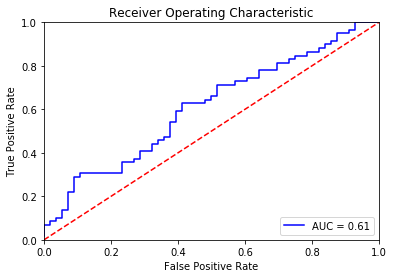

In [27]:
########################################
#print out binary class roc auc figure
############################################
fpr, tpr, threshold = metrics.roc_curve(y,y_xgb_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [28]:
########################################
#print out multiclass roc auc figure
############################################
#from sklearn.model_selection import cross_val_predict
#from sklearn.metrics import confusion_matrix

#cv = StratifiedKFold(n_splits = num_cv, random_state = r_seed)
#y_xgb_prob = cross_val_predict(xgb, X, y, cv = cv, method = 'predict_proba')

#import matplotlib.pyplot as plt
#plt.figure(figsize = (10, 8))
#plot_multiclass_roc_auc(y, y_xgb_prob, n_classes = 3, title = "xgb, SARC_high_var_0.2, 4 layers")
#plt.savefig('(0606)3class_roc_auc_xgb(4layers12k_0.1test)(SARC_high_var_0.2).png')

## Print out results for a given random seed

In [ ]:
print(xgb)
print("Auroc across all folds: %0.5f" % (xgb_multiclass_auroc))
print("Random seed is: ", r_seed)
print("The confusion martix is:\n", xgb_conf_mat)